In [1]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

### Область работы 1 (библиотеки)

In [2]:
# Данный блок в области 1 НЕ выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
#
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
#
# pip install

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt


### Область работы 2 (поиск  модели .... )

In [9]:
# Данный блок(и) НЕ выполняются преподавателем в области 2
# блок(и) предназначены для поиска лучшей модели 
# должен быть понятен и очевиден отбор параметров модели
# 
# Запрещается размещать данные блоки за пределами обасти 2
# Все блоки данной области должны быть выполнены
#
# ЗАПРЕЩАЕТСЯ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ НАБОР
#
# Путь к тренировочному набору
# 

path_train = 'train.csv' # содержит только имя файла, без имен папок !!!

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Volumes/MacMedia_MY/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       186
           1       0.41      0.30      0.35        23

    accuracy                           0.88       209
   macro avg       0.66      0.63      0.64       209
weighted avg       0.86      0.88      0.87       209

Accuracy: 0.8756
ROC AUC: 0.8883


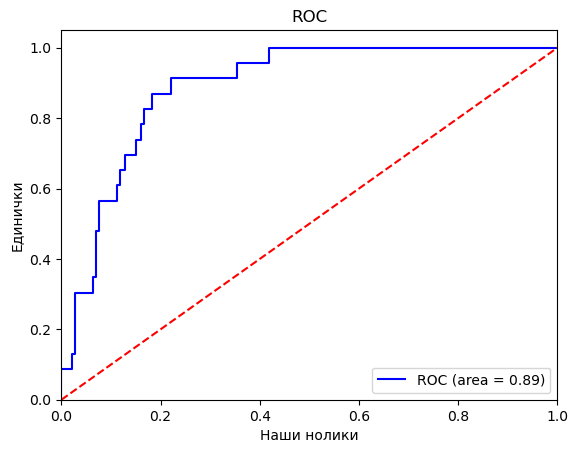

In [15]:
# Блок_1: Загрузка и предварительная обработка данных 
df = pd.read_csv(path_train)
mask = df.notna().all(axis=1) # сделали масочку
df = df[mask]
df = df.drop_duplicates() # убили жирную свинью 
# Удаляем выбросы, исключая значения ниже 1% и выше 99%, на 0,05 и 0,95 у меня с код почему-то не запустился 
for column in df.columns:
    lower_bound = df[column].quantile(0.01)
    upper_bound = df[column].quantile(0.99)
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df['quality_binary'] = np.where(df['quality'] < 7, 0, 1)


X = df.drop(columns=['quality', 'quality_binary'])
y = df['quality_binary']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# Блок_2: Моделька

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']  
}


model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print(f'Best Parameters: {grid_search.best_params_}')
print(classification_report(y_test, y_pred))

# Вычисляем точность 
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Вычисляем ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.4f}')

# Строим график ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Наши нолики')
plt.ylabel('Единички')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()